# Homework 5 - K-means, SVM, and Neural Networks
## CSCI 5622 - Fall 2021

***
**Name**: Alex Book
***

This assignment is due on Canvas by **11.59 PM on Thursday, December 9th**.
Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

# Assignment Setup

For this problem set, we'll be using three synthetic datasets plotted below. From left to right: co-centric circles `circles`, blobs with 5 centers `multi_blobs`, and blobs with 2 centers `binary_blobs`.

Each of the dataset instances has (`data`, `labels`) attributes that are split into `train` and `test` partitions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import io
from PIL import Image
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

def show_decision_surface(model, X, y, ax=None):
    """
    Helper function to visualize the decision surface of the trained model
    :param model with predict method
    :return: None
    """
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    x_grid, y_grid = np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)
    xx, yy = np.meshgrid(x_grid, y_grid)
    r1, r2 = xx.reshape(-1,1), yy.reshape(-1,1)
    grid = np.hstack((r1,r2))
    y_hat = model.predict(grid).reshape(-1,)
    zz = y_hat.reshape(xx.shape)

    if ax is None:
        plt.contourf(xx, yy, zz, cmap='PiYG')
        plt.scatter(X[:,0], X[:,1], c=y)
        plt.show()
    else:
        ax.contourf(xx, yy, zz, cmap='PiYG')
        ax.scatter(X[:,0], X[:,1], c=y)

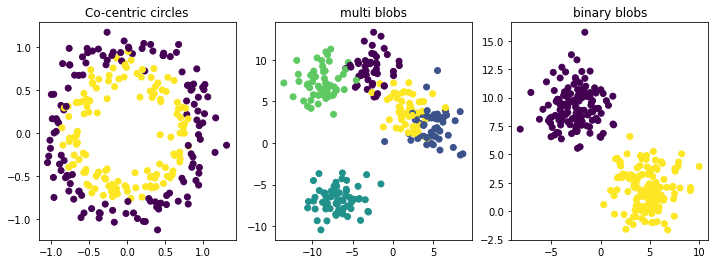

In [2]:
class Circles(object):
    def __init__(self):
        self.data, self.labels =  make_circles(n_samples=400, noise=0.1, random_state=42, factor=0.7)
        self.train_x, self.test_x, self.train_y, self.test_y =  train_test_split(self.data, self.labels,
                                                                                 test_size=0.33, random_state=42)
class DataBlobs:
    def __init__(self, centers):
        self.data, self.labels = make_blobs(n_samples=400, n_features=2, cluster_std=1.75,
                  centers=centers, shuffle=False, random_state=42)
        self.train_x, self.test_x, self.train_y, self.test_y =  train_test_split(self.data, self.labels,
                                                                                 test_size=0.33, random_state=42)

circles = Circles()
multi_blobs = DataBlobs(centers=5)
binary_blobs = DataBlobs(centers=2)

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4), fig.set_figwidth(12)
for i,(dataset, name) in enumerate([(circles, "Co-centric circles"),
                                    (multi_blobs, "multi blobs"),
                                    (binary_blobs, "binary blobs")]):
    axs[i].set_title(name)
    axs[i].scatter(dataset.train_x[:,0], dataset.train_x[:,1], c=dataset.train_y)
plt.show()

In the first problem, we'll be implementing K-means and evaluate it on the `multi_blobs` data. In the second prblem, we'll be implementing Support Vector Machines (SVM) with the kernel trick and test it on `circles` and `binary_blobs`. And in the last problem, we'll implement our Multi-Layer Perceptron from scratch and test it on the `circles` dataset.

The 3 problems are entirely independent and could be solved in any order you deem fitting.

# Problem 1 : K-means (30 points)

The goal of K-means is to partition the data into $k$ clusters such that the sum of intra-cluster variances is minimal.
We will be using Euclidean distance as our loss measure, so for cluster $C_i = \{x_1,x_2,... x_{m_i}\}$, its intra-cluster variance $V(C_i)$ is defined as:

$$
V(C_i) = \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

where $\mu_i = \frac{1}{m} \sum_{i=1}^{m_i} x_i$. $\mu_i$ is called the centroid of cluster $C_i$.

So for $k$ clusters, K-means objective is:
$$
\sum_{i=1}^{k}V(C_i) = \sum_{i=1}^{k} \sum_{j=1}^{m_i} ||x_j - \mu_i||^2
$$

Each point $x_i$ is assigned to the cluster of the closest centroid. Hence, finding The parition $\{C_1,C_2...C_k\}$ that minimizes the objective is equivalent to finding the optimal centroids.

Unfortunately, there is no algorithm that reaches the global optima for K-means, but we'll be implementing the most famous heuristic for the problem: Llyod algorithm. It works as follows:

- Initialize the centroids with unique random points from the data (`initialize_centroids`), objective = $+\infty$
- Repeat until convergence:
    - Compute the distances matrix $D$ between data points and centroids (`compute_distances`)
    - Use $D$ to assign the points to the cluster with the closest centroid (`computes_assignments`)
    - Update the centroids as centers of the new cluster assignments (`compute_centroids`)
    - Compute the new objective (`compute_objective`)
    - Stop if the objective does not improve

Due to floating errors, instead of a hard stop, we can terminate the algorithm when the objective improvement is lower than a tolerance $\epsilon$.



- **1.1 [2 points]** `initialize_centroids` : select K distinct points from the data `points` and use them as the initial centroids. Store these centroids in the class variable `self.centroids` as an `np.array` of shape $k \times d$.
- **1.2 [4 points]** `compute_distances` : compute the distance of each point $x_i$ to every centroid $c_j$ and return the result as a matrix `distances_matrix` of size $N \times k$ where `N` is the number of points and `k` is the chosen number of clusters to be found. A cell `(i,k)` shall contain the euclidean distance between point $x_i$ and centroid $m_k$. __Warning__ You're not allowed to use `scikit` (BallTree, `metrics` module..) or `scipy` for this question. Only `numpy` is allowed. (hint: use broadcasting tricks or Gram matrix).
- **1.3 [2 points]** `compute_assignments` : given the distances matrix of size $N \times k$ return a array of labels in which each element is an integer in the range $[0, k-1]$ and it represents which centroid it's closest to.
- **1.4 [4 points]** `compute_centroids` : You shall have the new assignment of clusters contained in the incoming `assignments` array to your $N$ points. Compute the new centroids depending on the new set of points that has been alloted to each cluster.
- **1.5 [6 points]** `fit` : This shall contain your main loop which implements the algorithm described above. You'll sequentially call the methods above to find the $k$ centroids. Break the loop when the objective improvement is within `tol`. At the end of each iteration, call the method `save_plot` to save the current clustering status and save the current objective value in the `history` list.

- **1.6 [3 points]** `predict` : Given [new] points, return their assigned clusters that were learned in the `fit` step.

In [3]:
class KMeans:
    def __init__(self, k):
        """
        @param k: (int) number of means/centroids to evaluate
        """
        self.k = k
        self.centroids = None
        self.plots = []

    def initialize_centroids(self, points):
        """
        Randomly select k distinct points from the dataset in self.X as centroids
        @param points: (np.ndarray) of dimension (N, d) N is the number of points
        @return: centroids array of shape (k, d)
        """
        centroids = None
        # Workspace 1.1
        # BEGIN code here
        
        rows = np.random.choice(points.shape[0], self.k)
        centroids = points[rows, :]
        
        #END
        return centroids

    def compute_distances(self, points):
        """
        Compute a distance matrix of size (N, k) where each cell (i, j) represents the distance between
        i-th point and j-th centroid. We shall use Euclidean distance here.
        #WARNING: do not use scikit's BallTree. Only numpy arrays
        @return: distances_matrix : (np.ndarray) of the dimension (N, k)
        """
        distances_matrix = np.zeros((points.shape[0], self.k))
        # Workspace 1.2
        # BEGIN code here
        
        num_rows, num_cols = distances_matrix.shape
        
        for i in range(num_rows):
            for j in range(num_cols):
                distances_matrix[i][j] = np.linalg.norm(self.centroids[j] - points[i])
        
        #END
        return distances_matrix

    @staticmethod
    def compute_assignments(distances_to_centroids):
        """
        Compute the assignment array of shape (N,) where assignment[i] = j if and only if point i
        belongs to the cluster of centroid j
        @param distances_to_centroids: The computed pairwise distances matrix of shape (N,k)
        @return: assignments array of shape (N,)
        """
        assignments = np.zeros((distances_to_centroids.shape[0],))

        # Workspace 1.3
        # BEGIN code here
        
        assignments = np.argmin(distances_to_centroids, axis=1)
        
        #END
        return assignments

    def compute_centroids(self, points, assignments):
        """
        Given the assignments array for the points, compute the new centroids
        @param assignments: array of shape (N,) where assignment[i] is the current cluster of point i
        @return: The new centroids array of shape (k,d)
        """
        # Workspace 1.4
        centroids = np.zeros((self.k, points.shape[1]))
        # BEGIN code here
        
        grouped_points = {}
        
        for i in range(len(points)):
            label = assignments[i]
            if label not in grouped_points.keys():
                grouped_points[label] = [points[i]]
            else:
                grouped_points[label].append(points[i])
                
        for key in grouped_points.keys():
            key = int(key)
            centroids[key] = np.average(grouped_points[key], axis=0)
        
        #END
        return centroids

    def compute_objective(self, points, assignments):
        return np.sum(np.linalg.norm(points - self.centroids[assignments], axis=1) ** 2)

    def fit(self, points, tol=1e-2):
        """
        Implement the K-means algorithm here as described above. Loop untill the improvement of the objective
        is lower than tol. At the end of each iteration, save the k-means objective and return the objective values
        at the end

        @param points:
        @return:
        """
        self.centroids = self.initialize_centroids(points)
        objective = np.inf
        assignments = np.zeros((points.shape[0],))
        history = []
        
        # Workspace 1.5

        while True:
            # BEGIN code here
            
            distances = self.compute_distances(points)
            assignments = self.compute_assignments(distances)
            self.centroids = self.compute_centroids(points, assignments)
            new_objective = self.compute_objective(points, assignments)
            history.append(new_objective)
            self.save_plot(points, assignments)
            
            if abs(objective-new_objective) <= tol:
                break
            else:
                objective = new_objective
            
            #END
        return history

    def predict(self, points):
        # Workspace 1.6
        assignments = np.zeros((points.shape[0],))
        # BEGIN code here
        
        distances = self.compute_distances(points)
        assignments = self.compute_assignments(distances)
        
        #END
        return assignments

    def save_plot(self, points, assignments):
        plt.ioff()
        figure = plt.figure()
        plt.scatter(points[:,0], points[:,1], c=assignments)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(figure)
        self.plots.append(buf)

    def show_progress(self):
        plots_total = len(self.plots)
        figure = plt.figure()
        def animate(t):
            t = int(t)
            plt.cla()
            self.plots[t].seek(0)
            im = Image.open(self.plots[t])
            plt.axis('off')
            plt.imshow(im)
        anim = matplotlib.animation.FuncAnimation(figure, animate, frames=plots_total)
        return anim

In [4]:
# show progress code
%matplotlib notebook
k_means = KMeans(5)
objective_history = k_means.fit(multi_blobs.data)
k_means.show_progress()

## Evaluating K-means
The easiest way to evaluate the clustering quality is to use the true labels. The natural question here is: which cluster corresponds to which label?

Let's first formulate the question using `multi_blobs` dataset. We have 5 clusters and 5 classes in our data. Let's create a _confusion matrix_ $C$ between the clusters and the labels so that $ C_{i,j} = \text{size}(\text{cluster}_i \cap \text{class}_j)$.

We model the unknown mapping using the $5\times 5$ boolean matrix $X$ such that $X_{i,j}=1$ if and only if $\text{cluster}_i$ is mapped to $\text{class}_j$.

To avoid having a cluster containing multiple classes, each row of $X$ is constrained to have only one non-zero entry.

Now, given a mapping $X$ and confusion matrix $C$, the number of correctly "classified" points (not really classification, more of clustering here) is:

\begin{align}
\#\text{correct} = \sum_i \sum_j C_{i,j} X_{i,j}
\end{align}
The goal is to find $\hat{X}$ that maximizes $\#\text{correct}$. To solve for $X$ we're going to use `scipy`'s `linear_sum_assignment`
([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)).

- **1.7 [5 points]** Complete `evaluate_clustering` to return the accuracy of K-means using the optimal mapping $\hat{X}$
defined above.

In [5]:
from scipy.optimize import linear_sum_assignment
def evaluate_clustering(trained_model, data, labels):
    # We can assume that the number of clusters and the number of class labels are the same
    clusters = trained_model.predict(data)
    # Workspace 1.7
    # BEGIN code here
    
    num_classes = len(np.unique(labels))
    C = np.zeros((num_classes, num_classes))
    
    for pred, actual in zip(clusters, labels):
        C[pred][actual] += 1
            
    row_inds, col_inds = linear_sum_assignment(C, maximize=True)
    
    num_correct = 0
    for row, col in zip(row_inds, col_inds):
        num_correct += C[row][col]
        
    accuracy = num_correct/len(data)
    
    #END
    return accuracy

- **1.8 [4 points]** Run K-means on the full `multi_blobs` for 20 runs. Plot the historgram of the clustering evaluation from `evaluate_clustering`. Also print the average clustering performance

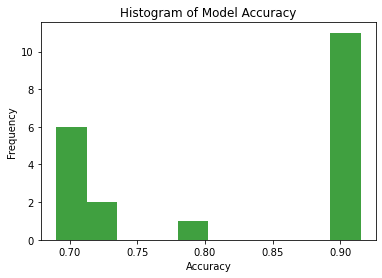

Average clustering performance: 0.8244999999999999


In [6]:
%matplotlib inline
accuracies = []
# Workspace 1.8
#BEGIN

for _ in range(20):
    model = KMeans(5)
    model.fit(multi_blobs.data)
    accuracy = evaluate_clustering(model, multi_blobs.data, multi_blobs.labels)
    accuracies.append(accuracy)
    
n, bins, patches = plt.hist(accuracies, 10, facecolor='g', alpha=0.75)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Histogram of Model Accuracy')
plt.show()

print(f'Average clustering performance: {np.mean(accuracies)}')

#END

## K-means++ (Bonus)
We have used a random centroid initialization in K-means. In K-means++, we initialize the centroids
in a (slightly) smarter way, and it works as the following:
- Choose the first centroid uniformly at random from the data points
- For the subsequent centroids:
    - compute the distances $(d_i)$ between the data points and the current centroids (distance between a point and its nearest centroid)
    - Pick a new centroid randomly with probability proportional to $(d_i ^2)$.


The rest of _K-means++_'s algorithm is exactly the same as _K-means_

- **1.9 (Bonus question) [5 points]**  Complete the `initialize_centroids` of K-means++ class and report K-means++ performance in a similar way to 1.8. Which model is better?

 You do not have to implement other methods. `KMeansPP(Kmeans)` implies that `KMeansPP` will inherit all the methods of `Kmeans` unless we choose to _override_ them (redefinition).

_Hint_: The weighted sampling can be done using `numpy`'s `choice` and its argument `p`. You do not have to worry about excluding the already picked centroids from the data. Once they're picked, their sampling weight should be equal to $0$. Make sure the probabilities sum to $1$.


In [7]:
class KMeansPP(KMeans):

    def initialize_centroids(self, points):
        #Workspace 1.9.a
        # Complete K-means++ centroid initialization. The first step (first centroid) is provided in the next line
        # Hint: You can modify self.centroids and use self.compute_distances to avoid re-coding distances computations
        centroids = points[np.random.choice(range(points.shape[0]), size=1)]
        #BEGIN 
        # code here
        #END
        return centroids

In [8]:
%matplotlib notebook
k_means_pp = KMeansPP(5)
objective_history = k_means_pp.fit(multi_blobs.data)
k_means_pp.show_progress()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
%matplotlib inline
accuracies = []
# Workspace 1.9.b
# Redo 1.8 using KMeansPP
#BEGIN 
# code here
#END

### Workspace 1.9.c
% Which model is better?

%BEGIN

%END

# Problem 2: Classification using Support Vector Machines and Kernel Trick (25 points)

We have seen during the class the dual form of the Support Vector Machine problem using a kernel $K$:

\begin{aligned}
 \max_{\alpha} \sum_i^m \alpha_i &- \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j K(x^{(i)},x^{(j)})
    \\
      s.t. \text{   } \alpha_i &\geq 0 \\
      \sum_i^m \alpha_i y^{(i)} &= 0
\end{aligned}

The simplest kernel $K$ is the linear kernel 
\begin{align}
K_{lin}(x^{(i)},x^{(j)}) = <x^{(i)}, x^{(j)}>
\end{align}
 with $<.,.>$ being the scalar product.

 We'll be also using the radial kernel $K_{rad}$:
\begin{align}
 K_{rad, \gamma}(x^{(i)},x^{(j)})  = \exp \big[-\gamma ||x^{(i)} - x^{(j)}||^2]
\end{align}
And the polynomial kernel $K_{poly, c, p}$:
\begin{align}
 K_{poly, c, p}(x^{(i)},x^{(j)})  = (<x^{(i)}, x^{(j)}> + c)^p
\end{align}

- **2.1. [6 pts]** Complete the implementation of the three kernels defined above

In [87]:
class LinearKernel(object):
    def compute(self, x1, x2):
        """
        Compute the kernel matrix
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = <x1[i], x2[j]>
        """
        # Workspace 2.1.a
        #BEGIN 
        K = np.zeros((x1.shape[0], x2.shape[0]))
        
        for i in range(len(x1)):
            for j in range(len(x2)):
                K[i][j] = np.dot(x1[i], x2[j])
        
        #END
        return K

class RadialKernel(object):

    def __init__(self, gamma):
        self.gamma = gamma

    def compute(self, x1, x2):
        """
        Compute the kernel matrix. Hint: computing the squared distances is similar to compute_distances in K-means
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = K_rad(x1[i],x2[j]) = exp(-gamma * ||x1[i] - x2[j]||^2)
        """
        # Workspace 2.1.b
        #BEGIN 
        K = np.zeros((x1.shape[0], x2.shape[0]))
        
        for i in range(len(x1)):
            for j in range(len(x2)):
                K[i][j] = np.exp(-self.gamma * (np.linalg.norm(x1[i] - x2[j])**2))
        
        #END
        return K

class PolynomialKernel(object):

    def __init__(self, c, p):
        self.c = c
        self.p = p

    def compute(self, x1, x2):
        """
        Compute the kernel matrix.
        @param x1: array of shape (m1,p)
        @param x2: array of shape(m2,p)
        @return: K of shape (m1,m2) where K[i,j] = (x1[i].x2[j] + c)^p
        """
        # Workspace 2.1.b
        #BEGIN 
        K = np.zeros((x1.shape[0], x2.shape[0]))
        
        for i in range(len(x1)):
            for j in range(len(x2)):
                K[i][j] = (np.dot(x1[i], x2[j]) + self.c)**self.p
        
        #END
        return K

Now we'll solve for $\alpha$ of the dual form  using the quadratic solver from [`cvxopt` package](https://cvxopt.org/userguide/coneprog.html#quadratic-programming).
To match the solver API, we need to rewrite the problem as:

\begin{aligned}
    \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ Gx \leq h
    \\
    \ Ax = b
\end{aligned}

So we'll define $P, q, G, h, A, b$  as:

\begin{align}
P_{i,j} &= y^{(i)}y^{(j)} K(x^{(i)},x^{(j)}) \text{,  matrix $P$ is of shape $m\times m$}\\
q &= -\overline{1} \text{,  vector of size m} \\
G &= diag(-\overline{1}) = -I_m\text{, diagonal matrix of -1} \\
h &= \overline{0} \text{,  vector of size m} \\
A &= y \text{, the labels vector} \\
b &= 0 \text{, a scalar (not to confuse with the intercept of SVM)}
\end{align}

- **2.2 [4 points]** Complete `quadratic_solver` by defining the different arrays $P, q, G, h, A$ and the scalar $b$. Make sure all arrays are of float type (it is important for `cvxopt`).


In [67]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np
solvers.options['show_progress'] = False
solvers.options['abstol'] = 1e-10
solvers.options['reltol'] = 1e-10
solvers.options['feastol'] = 1e-10

def quadratic_solver(K, y):
    """
    Solve for alpha of the dual problem, 
    @param K: Kernel matrix K of shape (m,m)
    @param y: labels array y of shape (m,)
    @return: optimal alphas of shape (m,)
    """

    # Workspace 2.2
    #BEGIN 
    # code here
    m = K.shape[0]
    P = np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            P[i][j] = K[i][j]*y[i]*y[j]
            
    q = -np.ones(m) # shape(m,1)
    
    G = -np.identity(m) # shape(m,m)
    
    h = np.zeros(m) # shape (m,)
    
    A = y.reshape(1, -1).astype(float) # shape (1,m)
    
    b = 0.0 # scalar
    #END
    sol = solvers.qp(matrix(P), matrix(q), matrix(G), matrix(h), matrix(A), matrix(b))
    alphas = np.array(sol['x'])
    alphas = alphas * (np.abs(alphas)> 1e-8) # zeroing out the small values
    return alphas.reshape(-1)

Once we get the optimal $\alpha$, then we can get the indices of the support vectors $S = \{i | \alpha_i >0 \}$. The intercept $b$ is computed as:

\begin{align}
b = \frac{1}{|S|}\sum_{m\in S}\big[ y^{(m)} - \sum_{i\in S} \alpha_i  y^{(i)}K(x^{(i)}, x^{(m)})\big]
\end{align}

and the prediction for a point $x$ would be:

\begin{align}
\hat{y} = \text{sign}\big[\sum_i y^{(i)}\alpha_i K(x,x^{(i)}) + b \big]
\end{align}

(you can see that we only need the features to compute the kernel $K$ and everything else is done as a function of the kernel. That's the beauty of kernel methods!).

- **2.3 [4 points]** Complete the `fit` method of SVM. You have to transform the 0-1 $y$ labels to (-1,1) before doing the computations since the SVM formulation assumes that the binary labels are (-1,1).

- **2.4 [3 points]** Complete the `predict` method to return the predicted labels of the provided points.


In [74]:
class SVM(object):

    def __init__(self, kernel):
        self.kernel = kernel
        self.X = None
        self.y = None
        self.intercept = None
        self.alphas = None


    def fit(self, X, y):
        """
        Transform y to (-1,1) and use self.kernel to compute K
        Solve for alphas and compute the intercept using the provided expression
        Keep track of X and y since you'll need them for the prediction
        @param X: data points of shape (m,p)
        @param y: (0,1) labels of shape (m,)
        @return: None
        """
        # Workspace 2.3
        self.X = X
        self.y = 2*y -1
        #BEGIN
        
        K = self.kernel.compute(self.X, self.X)
        self.alphas = quadratic_solver(K, self.y)
        S = np.where(self.alphas > 0)[0]
                
        self.intercept = 0
        for m in S:
            curr = self.y[m]
            for i in S:
                curr -= self.alphas[i]*self.y[i]*K[i][m]
            self.intercept += curr
            
        self.intercept /= len(S)
        
        #END

    def predict(self, X):
        """
        Predict the labels of points in X
        @param X: data points of shape (m,p)
        @return: predicted 0-1 labels of shape (m,)
        """
        # Workspace 2.4
        predicted_labels = np.zeros((X.shape[0],))
        #BEGIN
        
        for j, x in enumerate(X):
            curr = 0
            K = self.kernel.compute(x.reshape(1,-1), self.X)
            for i in range(len(self.X)):
                curr += self.y[i]*self.alphas[i]*K[0][i]
            curr += self.intercept
            predicted_labels[j] = np.sign(curr)
        
        #END
        return predicted_labels

We provide below an example of the expected plots for this problem using the linear kernel. 

- **2.5 [2 points]** Edit the cell to report the accuracy on the test sets for each of the two datasets visualized in the plots. How do you explain the obtained accuracies?

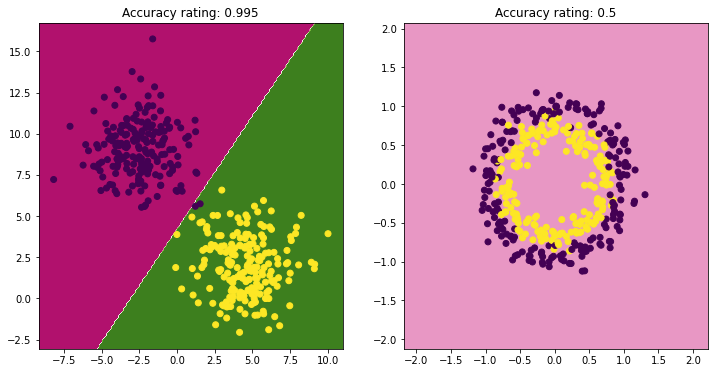

In [79]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
svm_linear = SVM(LinearKernel())
# Workspace 2.5.a
for i, dataset in enumerate([binary_blobs, circles]):
    svm_linear.fit(dataset.train_x, dataset.train_y)
    show_decision_surface(svm_linear, dataset.data, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN
    
    # need to conver the (-1,1) labels back to (0, 1)
    predictions = (svm_linear.predict(dataset.data) + 1) / 2
    correct = 0
    for j in range(len(predictions)):
        if predictions[j] == dataset.labels[j]:
            correct += 1
    axs[i].set_title(f'Accuracy rating: {correct/len(predictions)}')
    
    #END
plt.show()

### Workspace 2.5.b
% Explain the observed performance

%BEGIN

The observed performance makes sense, in that the binary blobs dataset was much more successfully classified than the circles dataset, as the blobs are almost able to be separated in a linear fashion (two purple points are outliers), whereas the circles are not at all able to be separated by a line.

%END

- **2.6 [3 points]** Plot and report SVM performance on the same datasets as in 2.5 using the radial kernel with $\gamma=2.0$. Describe the model performance and compare it to the linear kernel.

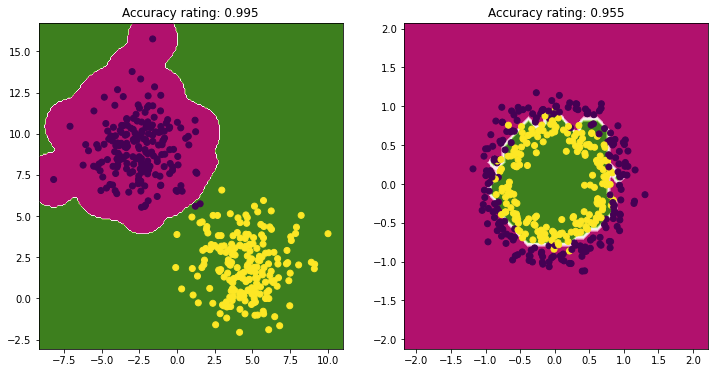

In [85]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 2.6.a
#BEGIN 

svm_radial = SVM(RadialKernel(gamma=2))
# Workspace 2.5.a
for i, dataset in enumerate([binary_blobs, circles]):
    svm_radial.fit(dataset.train_x, dataset.train_y)
    show_decision_surface(svm_radial, dataset.data, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN
    
    # need to conver the (-1,1) labels back to (0, 1)
    predictions = (svm_radial.predict(dataset.data) + 1) / 2
    correct = 0
    for j in range(len(predictions)):
        if predictions[j] == dataset.labels[j]:
            correct += 1
    axs[i].set_title(f'Accuracy rating: {correct/len(predictions)}')
    
    #END
plt.show()

#END

### Workspace 2.6.b
% Explain the observed performance

%BEGIN

The observed performance for the radial kernel makes sense as well, in that both datasets were fairly accurately classified. The blobs dataset didn't see an improvement, which is reasonable, as the groups were already separable using just a line. The circles dataset saw a huge improvement, as it wasn't feasible to be separated in a linear fashion, but the radial kernel should (and did) do a much better job.

%END

- **2.7 [3 points]** Plot and report SVM performance on the same datasets as in 2.5 using the polynomial kernel with $(c,p) = (1,5)$. Describe the model performance and compare it to the two previous kernels

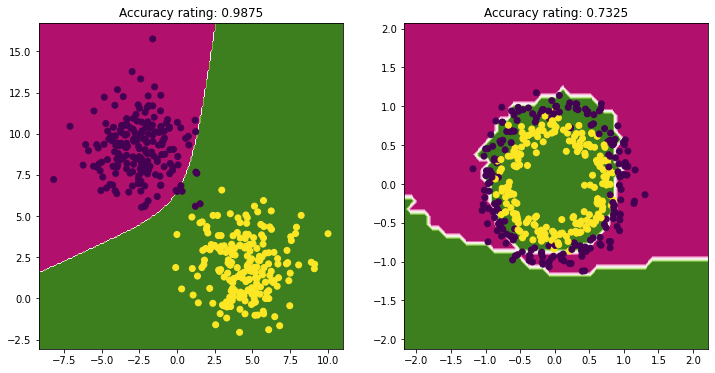

In [88]:
%matplotlib inline
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6), fig.set_figwidth(12)
#Workspace 2.7.a
#BEGIN

svm_polynomial = SVM(PolynomialKernel(c=1, p=5))
# Workspace 2.5.a
for i, dataset in enumerate([binary_blobs, circles]):
    svm_polynomial.fit(dataset.train_x, dataset.train_y)
    show_decision_surface(svm_polynomial, dataset.data, dataset.labels, axs[i])
    # Compute and print the accuracy, you can use axs[i].set_title to show it on the plot
    #BEGIN
    
    # need to conver the (-1,1) labels back to (0, 1)
    predictions = (svm_polynomial.predict(dataset.data) + 1) / 2
    correct = 0
    for j in range(len(predictions)):
        if predictions[j] == dataset.labels[j]:
            correct += 1
    axs[i].set_title(f'Accuracy rating: {correct/len(predictions)}')
    
    #END
plt.show()

#END

### Workspace 2.7.b
% Explain the observed performance

%BEGIN

Both datasets saw worse performance than with the linear and radial kernels. The blobs dataset is only a little bit worse, but the circles dataset is significantly worse than with the radial kernel (but still much better than the linear kernel, as expected).

%END

# Problem 3: Neural Networks (45 points)


In this final problem, we'll be implementing our own Neural Networks framework and use it to build a Multi-Layer Perceptron.
The MLP is a sequence of linear projections and activation functions, each of which will be implemented as a layer.

Each layer will have its own parameters (none for the activations), a `forward` method that applies the transformation,
and a `backward` method that back-propagates the gradient and computes the parameters gradients.


![Neural Network Example](./figure.png)
To understand how the mechanism works, let's consider the neural network that consists of two layers: $g_\theta:  \mathbb{R}^d \mapsto \mathbb{R}^p$ and $f_\psi: \mathbb{R}^p \mapsto \mathbb{R}^q$, where the parameters are optimized to minimize the loss $L$. 

Our dataset consists of samples $(x_i)$ with $d$ features and a one dimensional targets $(y_i)$. $g_\theta$ transforms  $(x_i)$ into $(u_i)$ and $f_\psi$ transforms $(u_i)$ into $(z_i)$. We'll be using the Mean Squared Error (MSE) for the loss function $L$.

The neural network will have two passes: forward pass where we transform the input into output, and backward pass where we backpropagates the gradient and compute the gradient of the loss w.r.t to parameters. Note that the gradient computation might require saving the input data from the forward pass since we son't be providing any data during the backward pass. We'll deal with that later.

Now, let's start from the last layer $f_\psi: \mathbb{R}^p \mapsto \mathbb{R}^q$, with parameter $\psi$. 


\begin{align}
MSE(y, z) = \frac{1}{m} \sum_{i=1}^{m} ||f_\psi(u_i) - y_i ||^2
\end{align}
, where $m$ is the sample size and $z_i = f_\psi(u_i)$.

To find the gradient of the loss w.r.t to $\psi$ we'll need the gradient of `MSE` w.r.t to its input $z$:

\begin{align}
 \frac{\partial MSE(y, z)}{\partial z}  = \frac{2}{m} \sum_{i=1}^{m} (z_i - y_i)
\end{align}

- **3.1 [2 points]** Complete `MSE`'s `forward` method that returns the MSE between `y` and `y_hat`
- **3.2 [3 points]** Complete `MSE`'s `backward` method that returns the derivative w.r.t to the input `z`. Notice that no argument is provided for the loss backward pass. You'll have to cache `y_pred` and `y_true` into your object-level `saved_arrays` variable during the `forward` call

In [ ]:
class MSE(object):
    def __init__(self):
        self.saved_arrays = None

    def forward(self, y_pred, y_true):
        """
        Compute the MSE loss
        @param y_pred: shape (m,q)
        @param y_true: shape (m,q)
        @return: scalar
        """
        # Workspace 3.1
        mse = 0
        #BEGIN 
        # code here
        #END
        return mse

    def backward(self):
        """
        Compute the gradient w.r.t to the prediction y_pred
        You'll have to cache the necessary quantities into your object-level 
            `saved_arrays` variable during the forward pass
        @return: shape (m,q)
        """
        # Workspace 3.2
        grad_input = None
        #BEGIN 
        # code here
        #END
        return grad_input

In [ ]:
# Testing MSE
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
expected_mse = 0.17090547876852463
expected_grad = np.array([[-0.24193655,  0.04041597], [ 0.46728084, -0.25158067]])
mse = MSE()
assert np.isclose(mse.forward(mock_X, mock_X/2), expected_mse, atol=1e-5)
assert np.alltrue(np.isclose(mse.backward(), expected_grad, atol=1e-5))


Now that we have the `grad_input` of `MSE`,  it's going to be `grad_output` from the perspective of the layer $f_\psi$.
- `grad_input` of layer $f_\psi$ is the derivative of the loss w.r.t the layer's input
- `grad_output` of layer $f_\psi$ is the derivative of the loss w.r.t to the layer's output (which is the next layer's input)


The `forward` method of a layer applies the transformation and keeps track of any relevant quantity for the gradient backpropagation.

The `backward` method is expected to return the gradient of the loss w.r.t to the input using the chain rule and the gradient of the parameters.
Now that we have $\frac{\partial L}{\partial z}$, we can use the chain rule to get

\begin{align}
\frac{\partial L }{\partial \psi} &= \frac{\partial L}{\partial z} \frac{\partial z}{\partial \psi}\\
& =  \frac{\partial L}{\partial z} \frac{\partial f_\psi(u)}{\partial \psi}
\end{align}


$\frac{\partial L }{\partial \psi}$ is the gradient that will be applied to the parameter $\psi$ and $\frac{\partial f_\psi(u)}{\partial \psi}$
is the derivative of the function w.r.t to its parameter. The next thing is to compute $\frac{\partial L }{\partial u}$ so that
the layer $g_\theta$ can use it to compute the gradient for its parameter $\theta$.


In our implementation, for layer $f_\psi$:
grad_input we want to compute in layer $f_\psi$
- $\frac{\partial L}{\partial z}$ is the provided `grad_output`
- $\frac{\partial L }{\partial \psi}$ is the `grad_parameter` (if any)
- $\frac{\partial L }{\partial u} = \frac{\partial L}{\partial z} \frac{\partial f_\psi(u)}{\partial u}$ is the 


The backward pass consists of sequentially doing what we've just mentioned for $f_\psi$

1. get the initial `grad_output` from the loss (top layer)
2. In reverse order:
    - pass current `grad_output` to the next layer
    - compute `grad_input` and `grad_parameters`
    - Store `grad_parameters`
    - `grad_output` <- `grad_input`
    - repeat 2
3. Apply the stored `grad_parameters` to the layers parameters

We'll apply this to our first layers: `sigmoid` and `ReLU`.
Since sigmoid and ReLU don't have parameters, we'll simply use a constant $\psi=0$  for uniformity.

- **3.3 [5 points]** Complete the Sigmoid activation layer. `forward` method applies the activation and `backward` should use the
chain rule to compute `grad_input` of the layer. You'll need to save the activation values to use them in `backward` call, for that you should use `self.saved_arrays` to cache them.

- **3.4 [5 points]** In a similar way, complete the ReLU activation layer. Note that $\frac{\partial \text{ReLU}(x)}{\partial x} = 1_{x\geq 0}$.

In [ ]:
class Layer(object):
    """
    Template Layer that will be used to implement all other layers
    """
    def __init__(self):
        self.saved_arrays = [] # You might need them for the backward pass
        self.parameters = None

    def forward(self, x):
        """
        In the forward pass we receive an array containing the input and return an array containing the output.
        You can cache arbitrary objects for use in the backward pass in self.saved_arrays
        @param x: input array of size (batch_size, d)
        @return: output array
        """
        self.saved_arrays = [x]
        return x

    def backward(self, grad_output):
        """
        In the backward pass we receive an array containing the gradient of the loss with respect to the output,
        and we need to compute the gradient of the loss with respect to the input and the gradient of the weights (default as 0)
        @param grad_output:
        @return: grad
        """
        saved, = self.saved_arrays
        grad_input = 0
        grad_parameters = 0

        return grad_output, grad_parameters

    def apply_gradient(self, gradients):
        """
        Method to apply the gradients to the layer parameters. It will be called by the optimizer.
        @param gradients:
        @return: None
        """
        pass


class Sigmoid(Layer):

    def forward(self, x):
        """
        Apply the sigmoid function to x. Don't forget to clip x to the interval [-25.0, 25.] before applying the activation
        @param x: input array of shape (m,k)
        @return: element-size sigmoid of shape (m,k)
        """
        sigmoid = np.zeros_like(x)
        # Workspace 3.3.a
        #BEGIN 
        # code here
        #END
        return sigmoid

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activatins don't have parameters, so 0 gradient is the default
        @param grad_output: input array of shape (m,k)
        @return: tuple (grad_input of shape element-size sigmoid of shape (m,k), 0)
        """
        grad_parameters = 0
        grad_input = 0

        # Workspace 3.3.b
        #BEGIN 
        # code here
        #END
        return grad_input, grad_parameters

class ReLU(Layer):

    def forward(self, x):
        """
        Apply the ReLU function to x. Don't forget to clip x to the interval [-25.0, 25.] before applying the activation
        @param x: input array of shape (m,k)
        @return: element-size ReLU of shape (m,k)
        """
        relu = 0
        # Workspace 3.4.a
        #BEGIN 
        # code here
        #END
        return relu

    def backward(self, grad_output):
        """
        Compute the grad_input and grad_parameters. Activatins don't have parameters, so 0 gradient is the default
        @param grad_output: input array of shape (m,k)
        @return: tuple (grad_input of shape element-size sigmoid of shape (m,k), 0)
        """
        grad_input = 0
        grad_parameters = 0
        # Workspace 3.4.b
        #BEGIN 
        # code here
        #END
        return grad_input, grad_parameters

In [ ]:
# Sigmoid Tests
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
grad_output = np.array([[ 0.19960269,  0.20993069], [-0.85814751, -0.41418101]])
sig_x = np.array([[0.38133797, 0.52019699], [0.71799983, 0.37679803]])
grad_sig_x = (np.array([[ 0.04709013,  0.05239704],[-0.17375434, -0.09725851]]), 0)
sigmoid = Sigmoid()
assert np.alltrue(np.isclose(sigmoid.forward(mock_X), sig_x, atol=1e-5))
assert np.alltrue(np.isclose(sigmoid.backward(grad_output)[0], grad_sig_x[0], atol=1e-5))

In [ ]:
# ReLU Tests
relu_x = np.array([[-0.,  0.08083195],[ 0.93456167, -0.]])
grad_relu_x = (np.array([[ 0.,  0.20993069],[-0.85814751, -0.]]), 0)
relu = ReLU()
assert np.alltrue(np.isclose(relu.forward(mock_X), relu_x, atol=1e-5))
assert np.alltrue(np.isclose(relu.backward(grad_output)[0], grad_relu_x[0], atol=1e-5))

Now we'll move to the exciting part. We'll implement our own _dense_ (linear) layer that has two parameters $\psi=(w,b)$,
with $w \in \mathbb{R}^{p\times q}$ being the weights array and $b \in \mathbb{R}^{q}$ the bias.
This layer $f_\psi$ projects a $p$ dimensional input $x$ into an $q$ dimensional space as follows:

\begin{align}
f_\psi(x) = xw + b
\end{align}

and its derivatives are:

\begin{align}
\frac{\partial f_\psi}{\partial x} &= w \\
\frac{\partial f_\psi}{\partial w} &= x^T \\
\frac{\partial f_\psi}{\partial b} &= 1_q
\end{align}

where $1_q$ is the ones vector with the same dimension as $b$

- **3.5 [10 points]** Complete the `Dense` layer

In [ ]:
class Dense(Layer):

    def __init__(self, input_dimension, output_dimension):
        """
        Initialize the parameters
        @param input_dimension: The dimension of the input data
        @param output_dimension: the dimension of the output
        """
        super(Dense, self).__init__()
        # Workspace 3.5.a
        # Intialize the bias and weights using random normal distibution
        # You should scale each array by 1 / sqrt(N) where N is the number of elements in the array
        self.bias = None
        self.weights = None
        #BEGIN 
        # code here
        #END
    def forward(self, x):
        """
        Apply the linear projection
        @param x of shape (m,input_dimension)
        @param z = xw + b of shape (m,output_dimension)
        """
        output = 0
        # Workspace 3.5.b
        #BEGIN 
        # code here
        #END
        return output


    def backward(self, grad_output):
        """
        Compute the gradients using the aforementioned formulas. Do not change the return signature
        @param grad_output: shape (m, output_dimension)
        @return: a tuple (grad_input, grad_weights, grad_bias)
                grad_input of shape (m, input_dimension)
                grad_weights of shape (input_dimension, output_dimension)
                grad_bias of shape (1, output_dimension)
        """
        grad_input = 0
        grad_weights = 0
        grad_bias = 0
        # Workspace 3.5.c
        #BEGIN 
        # code here
        #END
        return grad_input, grad_weights, grad_bias


    def apply_gradient(self, gradients):
        grad_weights, grad_bias = gradients
        self.weights -= grad_weights
        self.bias -= grad_bias

In [ ]:
# Dense layer test
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
np.random.seed(42)
dense = Dense(2,2)
dense.weights = dense.weights*0 +1
dense.bias = dense.bias*0 +1
dense.forward(mock_X)
gradients = dense.backward(grad_output)
dense_x = np.array([[0.59695885, 0.59695885],[1.43140033, 1.43140033]])
grad_dense_x = np.array([[ 0.40953338,  0.40953338],[-1.27232852, -1.27232852]])
grad_dense_weights = np.array([[-0.89857414, -0.48865751],[ 0.44792093,  0.22536898]])
grad_dense_bias = np.array([[-0.65854482, -0.20425032]])
assert np.alltrue(np.isclose(dense_x, dense.forward(mock_X), atol=1e-5))
assert np.alltrue(np.isclose(grad_dense_x, gradients[0], atol=1e-5))
assert np.alltrue(np.isclose(grad_dense_weights, gradients[1], atol=1e-5))
assert np.alltrue(np.isclose(grad_dense_bias, gradients[2], atol=1e-5))

Now that we implemented the layers, we need 2 more ingredients:
- Optimizer: to manage how to update the layers parameters using the computed gradients
- Network: to store our stack of layers and manage the forward and backward passes

- **3.6 [5 points]** Complete the `SGD` class following the details provided in the docstring

In [ ]:
class SGD(object):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.layers = None
        self.gradients = None

    def set_layers(self, layers):
        """
        Saves the layers stack
        @param layers: list of Layer instances (the same stack stored in the network)
        @return: None
        """
        self.layers = layers

    def set_gradients(self, gradients):
        """
        Saves the layers' parameters gradients before applying them.
        self.layers and self.gradients have the same size. self.gradients is a list of lists
        self.gradients[i] contains the list of parameters from self.layers.backward
        @param gradients: List of parameters gradients
        @return:
        """
        self.gradients = gradients

    def apply_gradients(self):
        """
        Multiply the gradients by the learning_rate before passing them to apply_gradient of the layers
        We loop through self.gradients (List of layers gradients computed from the backward pass).
        Then we call the corresponding layers apply_gradient with the scaled gradients.
        Hint: gradients[i] is a list on numpy as arrays that correspond to grad_parameters of layers[i]
        @return: None
        """
        # Workspace 3.6
        #BEGIN 
        # code here
        #END
        self.gradients = None

- **3.7 [5 points]** Complete the `forward` method of the `Network` class

We're providing the rest of the methods as a sanity check for the previous questions.
The network forward and backward pass should work without raising an error

In [ ]:
class Network(object):

    def __init__(self, optimizer, loss):
        self.optimizer = optimizer
        self.loss = loss
        self.layers = []
        self.optimizer.set_layers(self.layers)

    def add_layer(self, layer):
        self.layers.append(layer)

    def predict(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Given input x, apply the self.layers in the natural order and return the output
        @param x: shape (m,d)
        @return: array of shape (m,p) where p is the output dimension of the last linear layer
        """
        output = x
        # Workspace 3.7
        #BEGIN 
        # code here
        #END
        return output

    def backward(self):
        """
        Perform the backward pass, starts with the loss to get the first grad_output
        Loop through the layers in backward pass by providing the grad_output and 
        storing the grad_parameters from each layer
        Warning: should only be called after a forward call
        @return: list of grad_parameters from the layers
        """
        grad_output = self.loss.backward()
        parameters_gradients = []

        for layer in self.layers[::-1]:
            grads = layer.backward(grad_output)
            grad_output = grads[0]
            parameters_gradients.append(grads[1:])
        parameters_gradients = parameters_gradients[::-1]
        return parameters_gradients

    def fit(self, x, y):
        """
        Compute the output of the network and the loss based on y
        Call optimizers.set_gradients with the accumulated grad_parameters
        @param x: input sample of shape (batch_size, m)
        @param y: target array of shape (batch_size, 1)
        @return: Loss value
        """
        output = self.forward(x)
        loss = self.loss.forward(output, y)
        parameters_gradients = self.backward()
        self.optimizer.set_gradients(parameters_gradients)
        self.optimizer.apply_gradients()
        return loss

In [ ]:
# Testing SGD optimizer
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
mock_y = 0*mock_X + 1
expected_weights = np.array([[0.80399949, 0.80399949],[1.07958621, 1.07958621]])
sgd_network = Network(SGD(1e-1), MSE())
sgd_network.add_layer(Dense(2,2))
sgd_network.layers[0].weights = sgd_network.layers[0].weights*0 + 1
sgd_network.layers[0].bias = sgd_network.layers[0].bias*0 + 1
for _ in range(4):
    sgd_network.fit(mock_X, mock_y)
assert np.alltrue(np.isclose(sgd_network.layers[0].weights, expected_weights, atol=1e-5))

- **3.8 [5 points]** Create a neural network with your own choice of layers and activations. The last output should have dimension 1 to match that of our target. Since our target variable is either 0 or 1, you should use Sigmoid activation as the last layer to get outpouts in interval $[0,1]$. You'll be tweaking this to find a good choice of layers for the next questions

In [ ]:
# Workspace 3.8
#BEGIN 
# code here
#END

- **3.9 [5 points]** Using a batch size of 10, loop through the `circles` train parition for 100 epochs to minimize the MSE.
Compute and plot the MSE at the end of each epoch on the entire dataset (using `circles.data` and `circles.labels`). You might need to go back and tweak the neural network (layers, learning rate of SGD) to get good performance.

You'll have to try different learning rates to find the right one. You should expect an MSE <= 0.1 at the end of the training.

In [ ]:
batch_size = 10
epochs = 100
losses = []
# Workspace 3.9
#BEGIN 
# code here
#END
show_decision_surface(network, circles.data, circles.labels)

### Adam : Adaptive moment estimation (Bonus)
SGD optimizer the simplest we can use. However, the batch estimation of the gradient can be noisy. [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer smoothes out the gradient
using a moving average of past gradients (first moment) and scales them using a moving average estimate of their norm (second moment).
It works as follows:

- Parameters: learning rate $\alpha$, decay rates $\beta_1$ and $\beta_2$.
- Initialize: $t=0$, $m = 0$, $v = 0$ (each network parameter should have its corresponding $m$ and $v$)
- For each `apply_gradient` call given gradient $g$ do:
    - $t \leftarrow t+1$
    - $m \leftarrow \beta_1 m + (1-\beta_1) g$
    - $v \leftarrow \beta_2 v + (1-\beta_2) g^2$
    - $\hat{m} \leftarrow \frac{1}{1 - \beta_1 ^ t} m$
    - $\hat{v} \leftarrow \frac{1}{1 - \beta_2 ^ t} v$
    - apply gradient $\alpha .\hat{m} / (\sqrt{\hat{v}} + \epsilon)$ (division and sqrt are element wise, epsilon is a small constant to avoid zero division, we'll use $\epsilon =10^{-8}$)

**3.10 (Bonus Question) [5 points]** Complete Adam optimizer class and redo 3.9 using Adam optimizer instead. Try a learning rate that gave a bad performance using SGD.
Which optimizer is better? why?

In [ ]:
class Adam(SGD):
    def __init__(self, learning_rate, beta_1, beta_2):
        super(Adam, self).__init__(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.first_moment = None
        self.second_moment = None
        self.time_step = 0

    def apply_gradients(self):
        # Workspace 3.10.a
        #BEGIN
        # code here
        #END
        self.gradients = None

In [ ]:
# Testing Adam optimizer
mock_X = np.array([[-0.4838731,  0.08083195], [ 0.93456167, -0.50316134]])
mock_y = 0*mock_X + 1
expected_weights = np.array([[0.62432198, 0.62432198],[1.36305434, 1.36305434]])
adam_network = Network(Adam(1e-1, 0.9, 0.99), MSE())
adam_network.add_layer(Dense(2,2))
adam_network.layers[0].weights = adam_network.layers[0].weights*0 + 1
adam_network.layers[0].bias = adam_network.layers[0].bias*0 + 1
for _ in range(4):
    adam_network.fit(mock_X, mock_y)
assert np.alltrue(np.isclose(adam_network.layers[0].weights, expected_weights, atol=1e-5))

In [ ]:
batch_size = 10
epochs = 100
losses = []
network = None
# Workspace 3.10.b
#BEGIN 
# code here
plt.plot(np.arange(len(losses)), losses)
plt.show()
#END
show_decision_surface(network, circles.data, circles.labels)

### Workspace 3.10.c
% Which optimizer is better

%BEGIN

%END